# Visualization for VAE baseline and MAE

This is a visualization demo using a pre-trained MAE model. No GPU is needed.


## Download dataest

If you have downloaded COCO 2017 dataset, please ignore this cell.

In [ ]:
# COCO: trainval2017, val2017
# ! data_dir='data'
# ! dataset_dir='coco'
! mkdir -p data/  # if not exsit, create a folder

# annotations
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
! unzip -o annotations_trainval2017.zip -d data/coco/
! mv data/coco/annotations/ data/coco/ann_trainval2017/

# val set: 5k images
! wget http://images.cocodataset.org/zips/val2017.zip
! unzip -q -o ./val2017.zip -d data/coco/ # no verbose

# training set: 118k images
# ! wget http://images.cocodataset.org/zips/train2017.zip
# ! unzip -q -o ./train2017.zip -d data/coco/ # no verbose

! rm *.zip*

## Visualization of pre-trained MAE

### Check the shapes of MAE decoder' outputs

In [1]:
from transformers import AutoFeatureExtractor, ViTMAEForPreTraining
from PIL import Image
import requests

In [2]:
# transform image to inputs and build the pretrained MAE (with decoder)
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/vit-mae-base")
mae_with_decoder = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_inputs = feature_extractor(images=image, return_tensors="pt")

# fit one image into the pretrained MAE
img_outputs = mae_with_decoder(**img_inputs)
img_inputs.keys(), img_outputs.keys()

(dict_keys(['pixel_values']),
 odict_keys(['loss', 'logits', 'mask', 'ids_restore']))

In [4]:
print(f'Shape of outputs')
print(f'MAE input: {img_inputs["pixel_values"].size()}')
print(f"the mask: {img_outputs['mask'].size()}")
print(f"the ids_restore: {img_outputs['ids_restore'].size()}")
print(f"MAE decoder's output (logits): {img_outputs['logits'].size()}")

Shape of outputs
MAE input: torch.Size([1, 3, 224, 224])
the mask: torch.Size([1, 196])
the ids_restore: torch.Size([1, 196])
MAE decoder's output (logits): torch.Size([1, 196, 768])


### Mask and reconstruction visualization for pre-trained MAE

- load pretrained MAE model (with decoder)
- `utils.run_one_img()` support load image from internet or locally

    `run_one_img(url='', img_path='', model=None, verbose=True)`
    - url: str [optional], load an image via this url
    - img_path: str [optional], load an image via this load path
    - Note: url and img_path can't be empty at the same time.
    - model: ViTMAEForPreTraining, pretrained MAE model (with decoder)
    - verbose: bool, if `verbose=True`, print `rec_loss` and the process of making pixel-wise mask and reconstruction


In [5]:
from utils import mae_run_one_img, show_image
from params import PRETRAIN_DATASET_PARAMS as PDP
from transformers import ViTMAEForPreTraining

In [6]:
# load pretrained MAE model (with decoder)
pretrained_model = 'facebook/vit-mae-base'
mae_with_decoder = ViTMAEForPreTraining.from_pretrained(pretrained_model)

rec_loss: tensor(0.1889, grad_fn=<DivBackward0>)
patch mask -> unpatch_mask -> pixel mask projection: 
torch.Size([1, 196]) -> torch.Size([1, 196, 768]) -> torch.Size([1, 3, 224, 224])
pred of decoder -> pixel-wise pred: 
torch.Size([1, 196, 768]) -> torch.Size([1, 3, 224, 224])


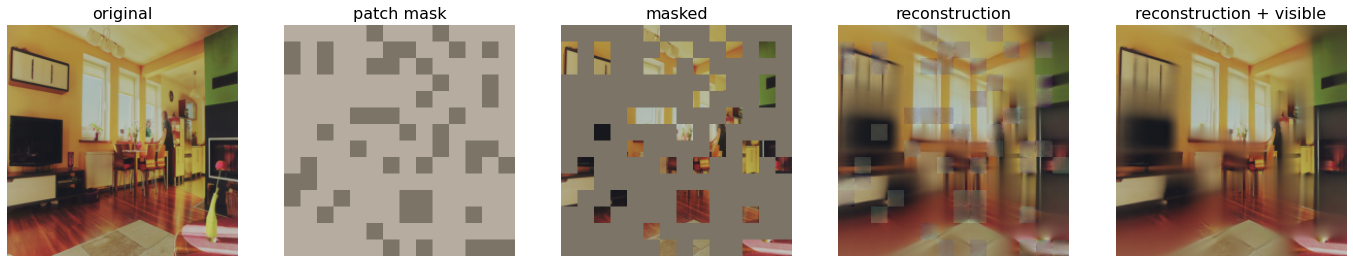

In [7]:
# show mask and reconstruction for one image
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
mae_run_one_img(url=url, model=mae_with_decoder, verbose=True) 

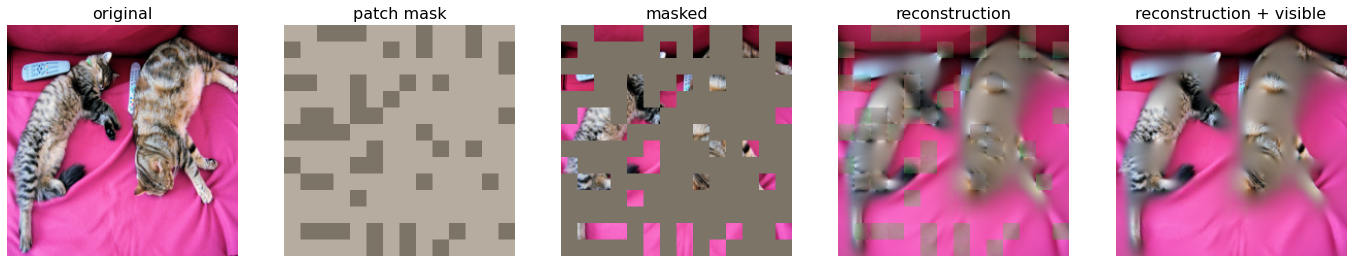

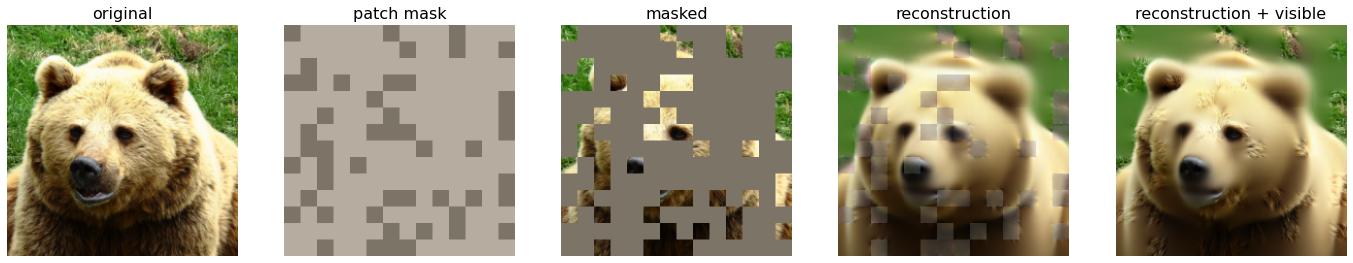

In [8]:
# load image from internet
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
mae_run_one_img(url=url, model=mae_with_decoder, verbose=False)

# NOTE: using img_path requires downloaded COCO 2017 dataset
img_path = "data/coco/val2017/000000000285.jpg"
mae_run_one_img(img_path=img_path, model=mae_with_decoder, verbose=False)

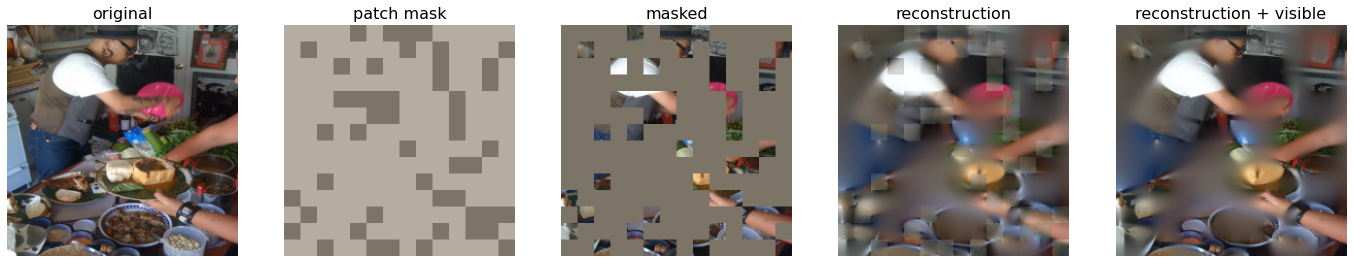

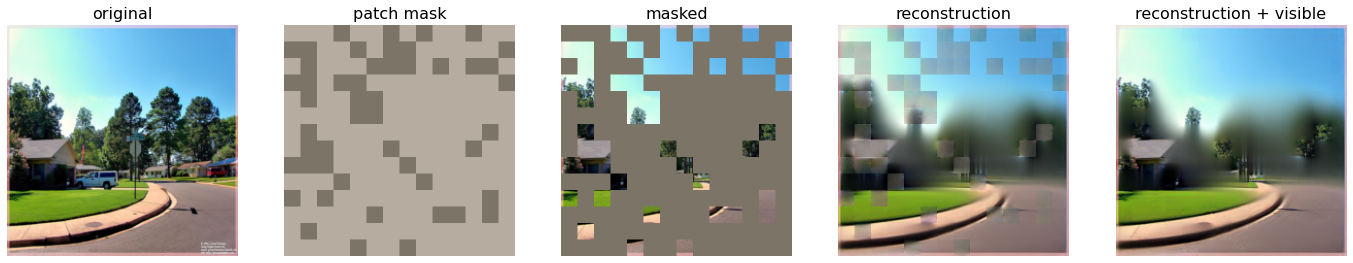

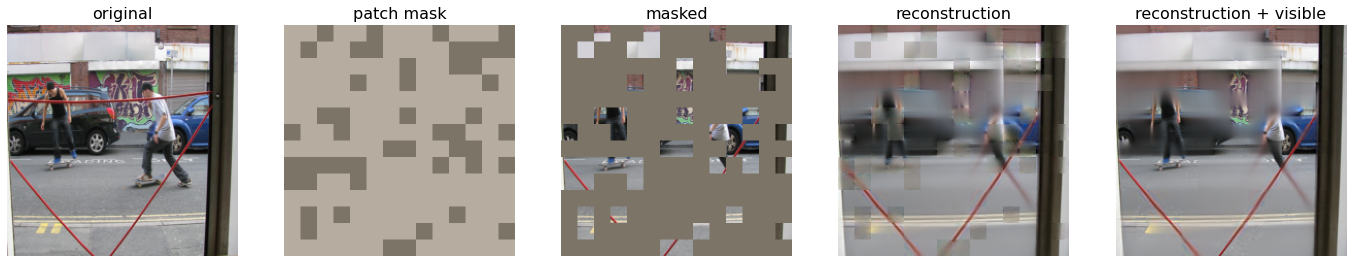

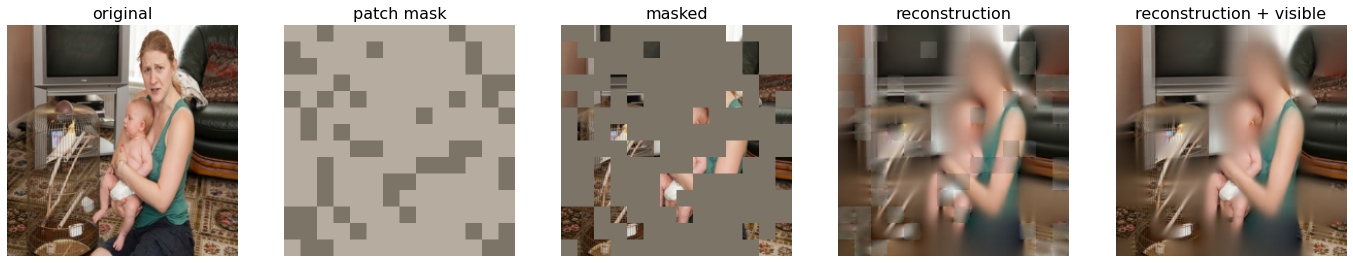

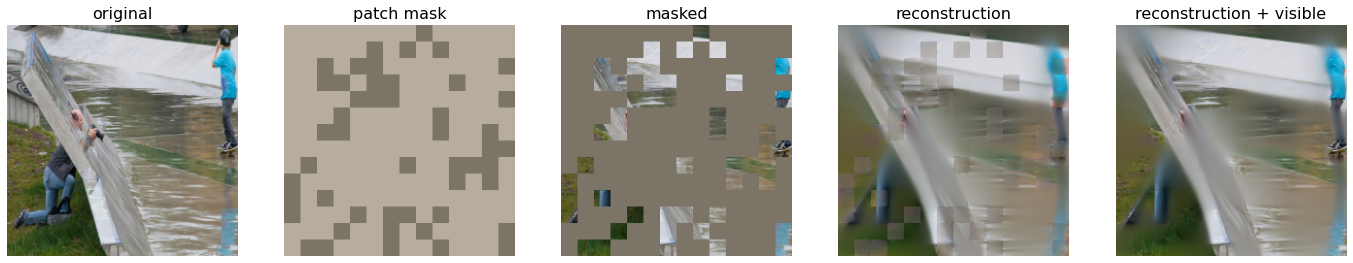

In [9]:
# Iterate local images and show their masks and reconstruction
import os

rootdir = "data/coco/val2017/"
num_images = 5
model = mae_with_decoder
verbose = False

for subdir, dirs, files in os.walk(rootdir):
    for i, file in enumerate(files):
        #print os.path.join(subdir, file)
        img_path = subdir + file
        # print(img_path)
        mae_run_one_img(img_path=img_path, model=model, verbose=verbose)
        if i >= num_images - 1:
            break

## Visualization for VAE baseline

Mask: patch-wise and pixel-wise

Reconstruction: output of VAE decoder

In [10]:
from models.vae import VAE
from models.standalone_vae import StandaloneVAE
from models.params import VAE_PARAMS
from models.params import STANDALONE_VAE_PARAMS as SVAEP
from masks import PixelMask, PatchMask

from transformers import AutoFeatureExtractor
from PIL import Image

from torchsummary import summary
import matplotlib.pyplot as plt

In [11]:
# FIXME: can't construct a vae
# vae = VAE(VAE_PARAMS)
# summary(vae, input_size=(3,224,224))

In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/vit-mae-base")

### pixel-wise mask

In [13]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_inputs = feature_extractor(images=image, return_tensors="pt")

img_input = img_inputs['pixel_values']
print(f"img_input size: {img_input.size()}")

pixel_mask_maker = PixelMask(0.25)
pixel_masked_img, pixel_mask = pixel_mask_maker(img_input)
pixel_masked_img.size(), pixel_mask.size()

img_input size: torch.Size([1, 3, 224, 224])


(torch.Size([1, 3, 224, 224]), torch.Size([1, 224, 224]))

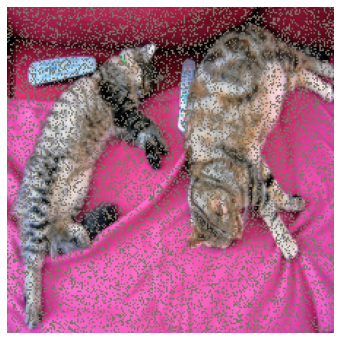

In [14]:
plt.figure(figsize=(6, 6))
show_image(pixel_masked_img[0])

### patch-wise mask

FIXME: `patch_size` does work in the right way

In [18]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_inputs = feature_extractor(images=image, return_tensors="pt")

img_input = img_inputs['pixel_values']
print(f"img_input size: {img_input.size()}")

# FIXME: patch_size=56, should generate less and big patches
patch_mask_maker = PatchMask(mask_ratio=0.25, patch_size=56)
patch_masked_img, patch_mask = patch_mask_maker(img_input)
patch_masked_img.size(), patch_mask.size()

img_input size: torch.Size([1, 3, 224, 224])


(torch.Size([1, 3, 224, 224]), torch.Size([1, 3136]))

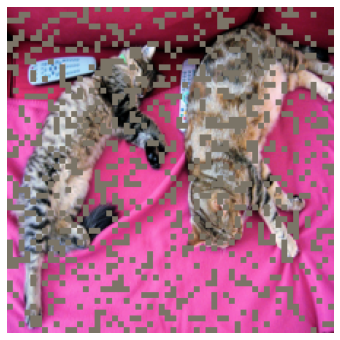

In [19]:
plt.figure(figsize=(6, 6))
show_image(patch_masked_img[0])

img_input size: torch.Size([1, 3, 224, 224])


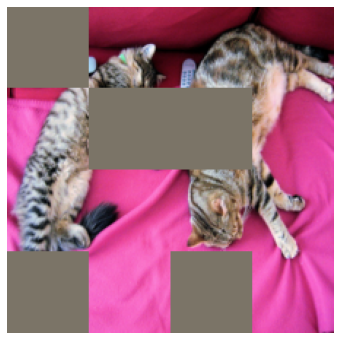

In [20]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_inputs = feature_extractor(images=image, return_tensors="pt")

img_input = img_inputs['pixel_values']
print(f"img_input size: {img_input.size()}")

# FIXME: patch_size=4, should generate more and small patches
patch_mask_maker = PatchMask(mask_ratio=0.25, patch_size=4)
patch_masked_img, patch_mask = patch_mask_maker(img_input)

plt.figure(figsize=(6, 6))
show_image(patch_masked_img[0])

Show patch-wise masked image and reconstruction 

- Build a VAE first
- `vae_show_one_image(url='', img_path='', model=None, mask_ratio=0.25, patch_size=16, is_patch=True, verbose=True)`
                       
    - support load image from internet or locally
        - url: str [optional], load an image via this url
        - img_path: str [optional], load an image via this load path
        - Note: url and img_path can't be empty at the same time.
    - model: VAE
    - mask_ratio & patch_size
    - is_patch: bool, if is_patch = True, generate patch-wise masked image, otherwise, create pixel-wise masked image
    <!-- - verbose: bool, if `verbose=True`, print `rec_loss` and the process of making pixel-wise mask and reconstruction -->


In [21]:
from utils import vae_show_one_image

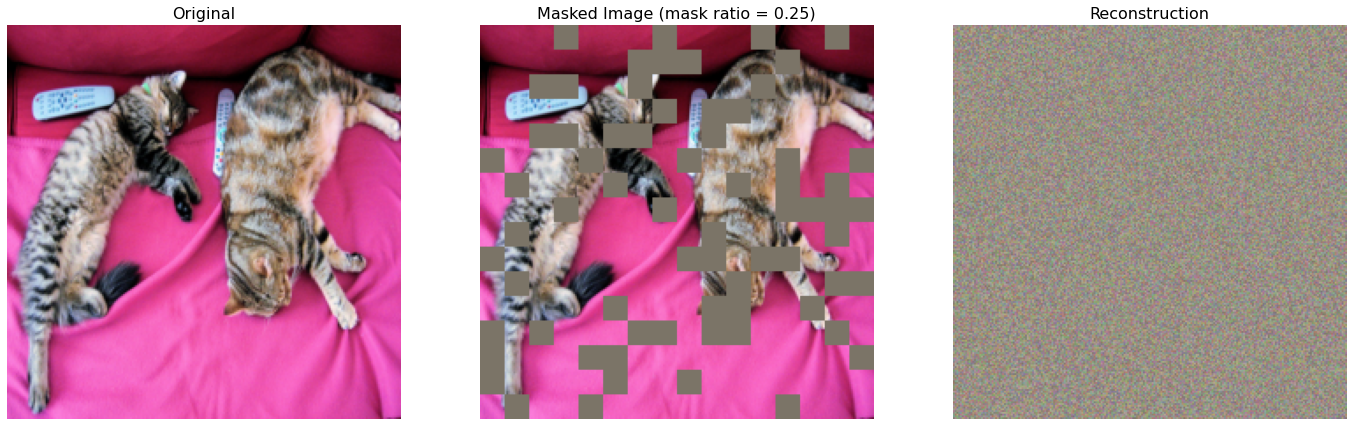

In [33]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
vae_show_one_image(url=url, model=None, mask_ratio=0.25, 
                   patch_size=16, is_patch=True, verbose=True)

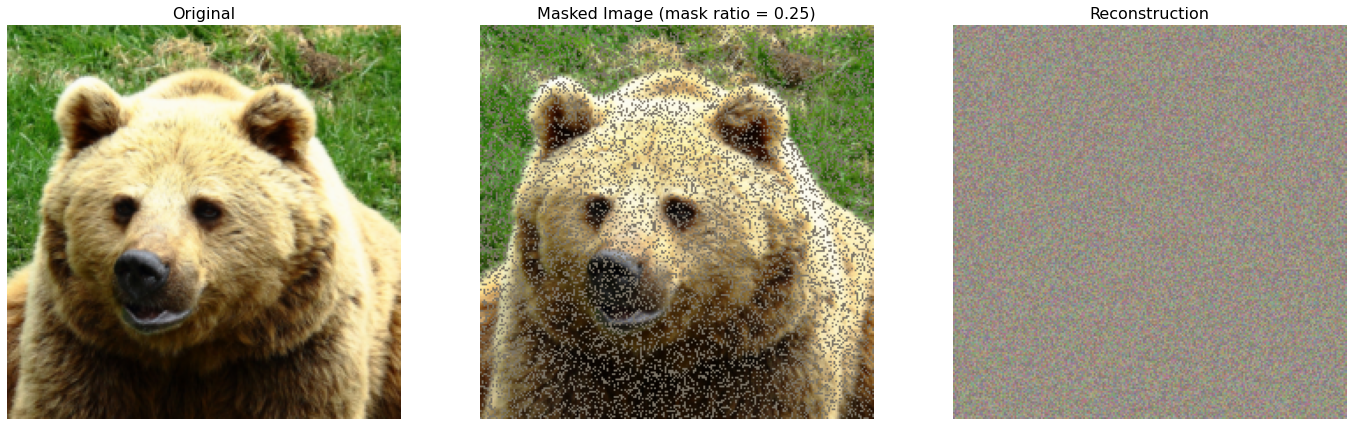

In [34]:
# NOTE: using img_path requires downloaded COCO 2017 dataset
img_path = "data/coco/val2017/000000000285.jpg"
vae_show_one_image(img_path=img_path, model=None, mask_ratio=0.25, 
                   patch_size=16, is_patch=False, verbose=True)

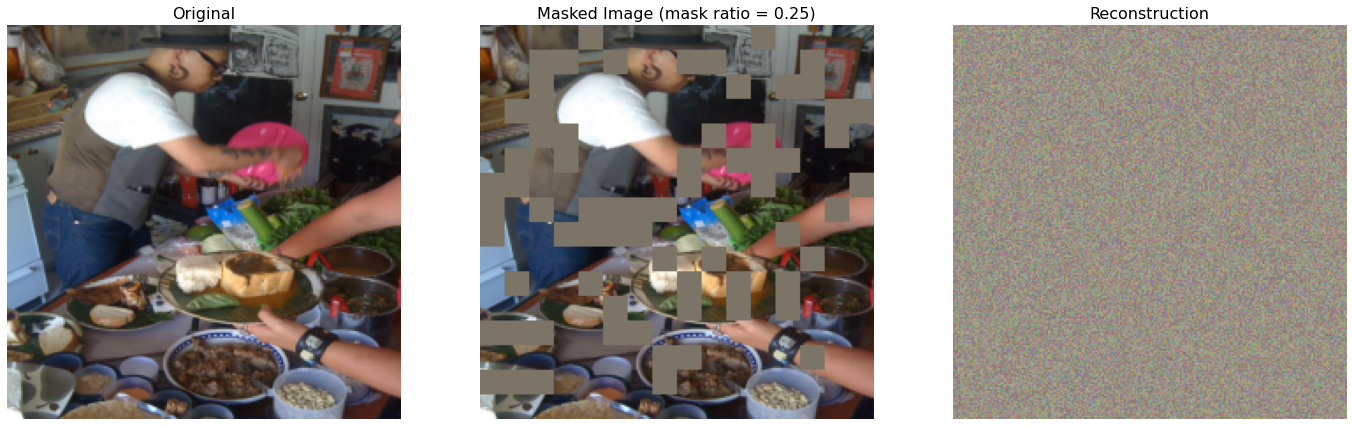

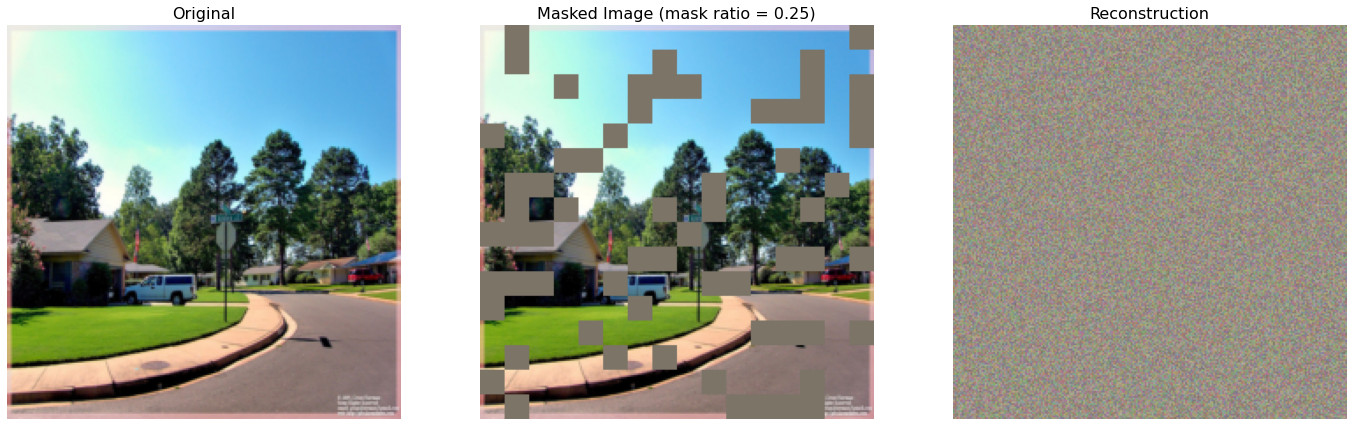

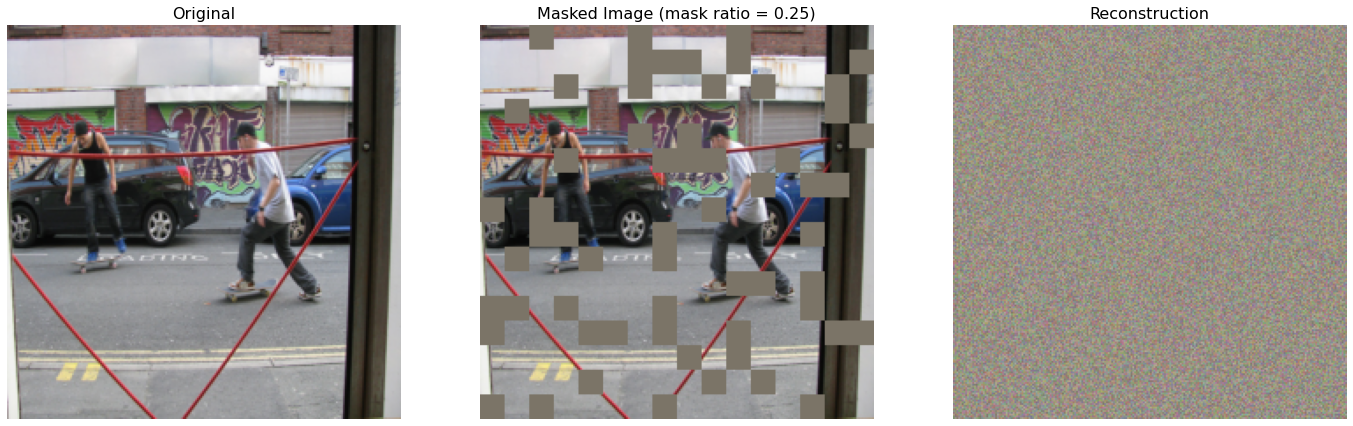

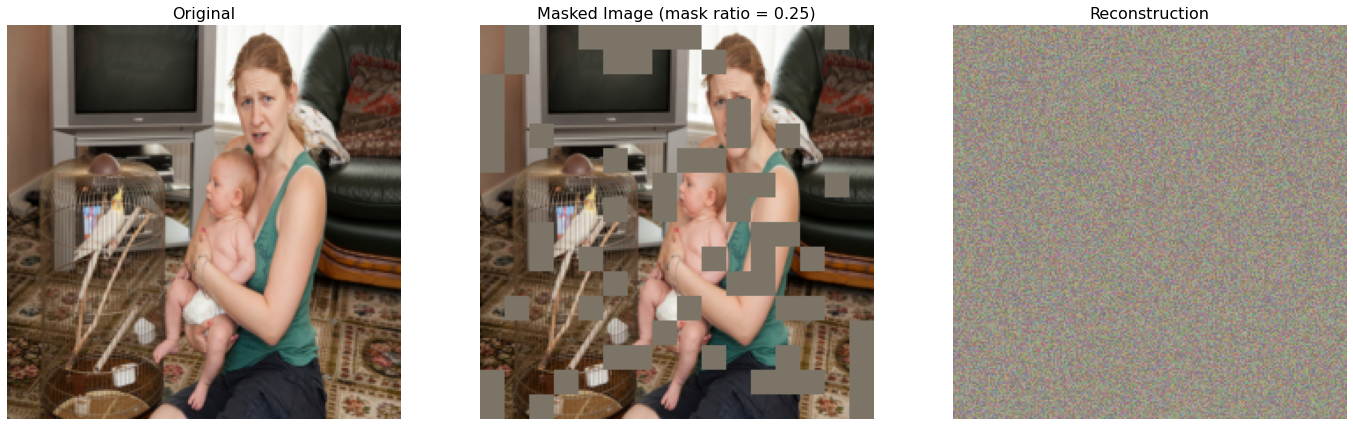

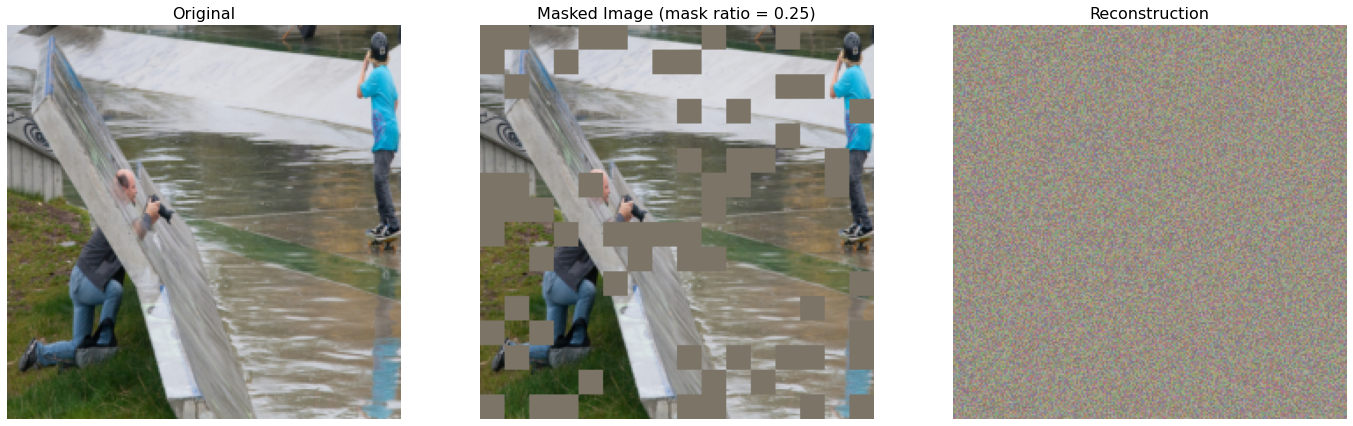

In [32]:
# Iterate local images and show their masks and reconstruction
import os

rootdir = "data/coco/val2017/"
num_images = 5
# FIXME: build an VAE here
model = None
verbose = False
mask_ratio = 0.25 
patch_size = 16
is_patch = True
verbose = True

for subdir, dirs, files in os.walk(rootdir):
    for i, file in enumerate(files):
        #print os.path.join(subdir, file)
        img_path = subdir + file
        # print(img_path)
        vae_show_one_image(img_path=img_path, model=model, mask_ratio=mask_ratio, 
                           patch_size=patch_size, is_patch=is_patch, verbose=verbose)
        if i >= num_images - 1:
            break

In [25]:
standalone_vae = StandaloneVAE(SVAEP)
summary(standalone_vae, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 53, 53]          24,608
         LeakyReLU-2           [-1, 32, 53, 53]               0
            Conv2d-3           [-1, 64, 16, 16]         131,136
       BatchNorm2d-4           [-1, 64, 16, 16]             128
         LeakyReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6            [-1, 128, 7, 7]         131,200
       BatchNorm2d-7            [-1, 128, 7, 7]             256
         LeakyReLU-8            [-1, 128, 7, 7]               0
            Conv2d-9            [-1, 256, 3, 3]         295,168
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
           Conv2d-12            [-1, 512, 1, 1]       1,180,160
      BatchNorm2d-13            [-1, 512, 1, 1]           1,024
        LeakyReLU-14            [-1, 51